In [4]:
import tensorflow as tf
print(tf.__version__)

2.7.0


In [5]:

import os
import zipfile
import shutil
# from google.colab import drive
# drive.mount('/content/drive')
# import tensorflow as tf
import cv2
import matplotlib.pyplot as plt


In [6]:
local_zip = 'KDEF_and_AKDEF.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
try:
    os.makedirs('Thesis_Emodet', exist_ok=True)
except OSError as error:
    print(error)
zip_ref.extractall('Thesis_Emodet')
zip_ref.close()

In [7]:
files = []
dir = []
basepath = 'Thesis_Emodet/KDEF_and_AKDEF/KDEF'
for entry in os.listdir(basepath):
    sub=[]
    dir.append(basepath+'/'+entry+'/')
    for file in os.listdir(basepath+'/'+entry):
        sub.append(file)
    files.append(sub)

root='Thesis_Emodet/emotions/'
emotion_type=['AF','AN','DI','HA','NE','SA','SU']



In [ ]:
for sublist in range(len(files)):
    for file in files[sublist]:
        for i in range (len(emotion_type)):
            if file[4:6] == emotion_type[i]:
                try:
                    os.makedirs(root+emotion_type[i], exist_ok=True)
                except OSError as error:
                    print(error)
                shutil.copy(dir[sublist]+file, root+emotion_type[i])
                break

In [8]:
checkpoint_path = "Checkpoints/test_1_cp/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)



# This may generate warnings related to saving the state of the optimizer.
# These warnings (and similar warnings throughout this notebook)
# are in place to discourage outdated usage, and can be ignored.

In [9]:
# Call_back function for stopping training after a certain level


class myCallback(tf.keras.callbacks.Callback):# Your Code
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('acc')>.999):
            print("\nReached 99.9% accuracy so cancelling training!")
            self.model.stop_training = True

AccuracyLimiterCallback = myCallback()

In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# For data split into test & validation
train_datagen = ImageDataGenerator(rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    fill_mode='nearest',
    validation_split=0.15) # set validation split

batch_size=32
img_height=400
img_width=300
# train_data_dir='/content/Thesis_Emodet/emotions/' # source directory for training images
train_data_dir=root
train_generator = train_datagen.flow_from_directory(
    directory=train_data_dir,
    color_mode='grayscale',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training') # training data

validation_generator = train_datagen.flow_from_directory(
    directory=train_data_dir, # same directory as training data
    color_mode='grayscale',
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation') # validation data




Found 4165 images belonging to 7 classes.
Found 733 images belonging to 7 classes.


In [11]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(img_height , img_width, 1)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fifth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(7, activation='softmax')
])


model.summary()

model.compile(loss = 'categorical_crossentropy', optimizer='adam', metrics = ['acc'])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 398, 298, 64)      640       
                                                                 
 batch_normalization (BatchN  (None, 398, 298, 64)     256       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 199, 149, 64)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 197, 147, 64)      36928     
                                                                 
 batch_normalization_1 (Batc  (None, 197, 147, 64)     256       
 hNormalization)                                                 
                                                        

2022-02-23 11:30:30.792808: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 11:30:30.846258: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 11:30:30.846360: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-23 11:30:30.846808: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [12]:
history = model.fit_generator(
            train_generator,
            validation_data = validation_generator,
            epochs = 100,
            callbacks=[cp_callback,AccuracyLimiterCallback],
            verbose = 1)
model.save ('model_saved/test_1/test_1.h5')

/tmp/ipykernel_335034/1981197724.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(


Epoch 1/100


2022-02-23 11:34:27.298726: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8301
2022-02-23 11:34:28.698200: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-02-23 11:34:28.698261: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 3.04GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-02-23 11:34:28.925669: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2022-02-23 11:34:29.407962: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of 

131/131 [==============================] - ETA: 0s - loss: 2.6793 - acc: 0.1373

2022-02-23 11:35:28.659782: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.94GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-02-23 11:35:28.659844: W tensorflow/core/common_runtime/bfc_allocator.cc:275] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.94GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.



Epoch 00001: saving model to Checkpoints/test_4 cp/cp.ckpt
131/131 [==============================] - 63s 455ms/step - loss: 2.6793 - acc: 0.1373 - val_loss: 2.3377 - val_acc: 0.1460
Epoch 2/100
131/131 [==============================] - ETA: 0s - loss: 2.3856 - acc: 0.1503
Epoch 00002: saving model to Checkpoints/test_4 cp/cp.ckpt
131/131 [==============================] - 43s 325ms/step - loss: 2.3856 - acc: 0.1503 - val_loss: 2.2218 - val_acc: 0.1432
Epoch 3/100
131/131 [==============================] - ETA: 0s - loss: 2.2327 - acc: 0.1405
Epoch 00003: saving model to Checkpoints/test_4 cp/cp.ckpt
131/131 [==============================] - 38s 291ms/step - loss: 2.2327 - acc: 0.1405 - val_loss: 2.0946 - val_acc: 0.1255
Epoch 4/100
131/131 [==============================] - ETA: 0s - loss: 2.1051 - acc: 0.1561
Epoch 00004: saving model to Checkpoints/test_4 cp/cp.ckpt
131/131 [==============================] - 38s 291ms/step - loss: 2.1051 - acc: 0.1561 - val_loss: 2.0441 - val_acc

<Figure size 432x288 with 0 Axes>

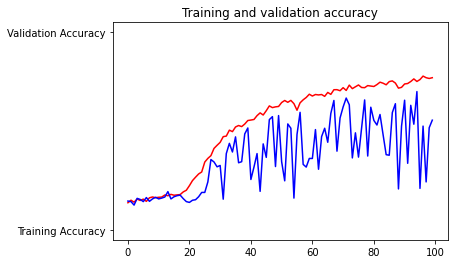

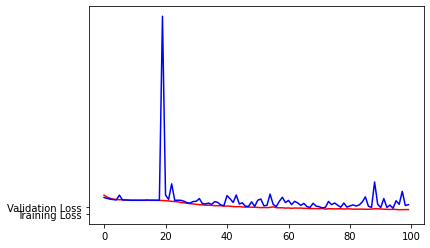

<Figure size 432x288 with 0 Axes>

In [13]:
%matplotlib inline

import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['acc']
val_acc=history.history['val_acc']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r', "Training Accuracy")
plt.plot(epochs, val_acc, 'b', "Validation Accuracy")
plt.title('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r', "Training Loss")
plt.plot(epochs, val_loss, 'b', "Validation Loss")
plt.figure()